In [1]:
# %% #General
import warnings
warnings.filterwarnings ( "ignore" )
import os
from time import time
from datetime import datetime,timedelta  #time,
import matplotlib.pyplot as plt
import multiprocess as mp
from IPython.display import display

# Scientific and data
import json
import numpy as np
from tqdm import tqdm
import pandas as pd
import  xarray as xr
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.interpolate import griddata
from functools import partial
eps = np.finfo(np.float).eps

# pytorch
import torch , torchvision
import torch.utils.data
import torch.nn as nn
from torch import functional as F
from torch import Tensor
torch.manual_seed(8318)


# Local modules
import  global_settings as gs
import data_loader as dl
import preprocessing as prep
from utils import create_and_configer_logger # from utils import df_multi_core
# %%

In [2]:
def _df_split(tup_arg, **kwargs):
	split_ind, df_split, df_f_name = tup_arg
	return (split_ind, getattr(df_split, df_f_name)(**kwargs))

def df_multi_core(df, df_f_name, subset=None, njobs=-1, **kwargs):
	# %% testing multiproccesing from: https://gist.github.com/morkrispil/3944242494e08de4643fd42a76cb37ee
	if njobs == -1:
		njobs = mp.cpu_count()
	pool = mp.Pool(processes=njobs)

	try:
		df_sub = df[subset] if subset else df
		splits = np.array_split(df_sub, njobs)
	except ValueError:
		splits = np.array_split(df, njobs)

	pool_data = [(split_ind, df_split, df_f_name) for split_ind, df_split in enumerate(splits)]
	results = pool.map(partial(_df_split, **kwargs), pool_data)
	pool.close()
	pool.join()
	results = sorted(results, key=lambda x:x[0])
	results = pd.concat([split[1] for split in results])
	return results

def get_sample_ds(row):
	mol_path = row.molecular_path
	lidar_path = row.lidar_path
	bin_r0 = row.bin_r0
	bin_r1 = row.bin_r1
	t0 = row.start_time_period
	t1 = row.end_time_period
	full_ds = [ prep.load_dataset ( path ) for path in [ lidar_path , mol_path ] ]
	tslice = slice ( t0 , t1 )
	profiles = [ 'range_corr' , 'attbsc' ]
	sliced_ds = [ ds_i.sel ( Time = tslice ,
	                         Height = slice(float(ds_i.Height[bin_r0].values),float(ds_i.Height[bin_r1].values)) ) [ profile ]
	         for ds_i , profile in zip ( full_ds , profiles ) ]
	return sliced_ds,full_ds


def make_interpolated_image(nsamples,im):
    """Make an interpolated image from a random selection of pixels.

    Take nsamples random pixels from im and reconstruct the image using
    scipy.interpolate.griddata.

    """
    nx, ny = im.shape[1], im.shape[0]
    X, Y = np.meshgrid(np.arange(0, nx, 1), np.arange(0, ny, 1))
    ix = np.random.randint(im.shape[1], size=nsamples)
    iy = np.random.randint(im.shape[0], size=nsamples)
    samples = im[iy,ix]
    int_im = griddata((iy, ix), samples, (Y, X),method = 'nearest',fill_value = 0)
    return int_im

def get_aerBsc_profile_ds(path,profile_df):
	cur_profile = prep.load_dataset(path)
	height_units = 'km'
	height_scale = 1e-3 # converting [m] to [km]
	bsc_scale = 1e+3 # converting [1/m sr] to to [1/km sr]
	heights_indx = height_scale * (cur_profile.height.values + cur_profile.altitude.values)
	start_time = datetime.utcfromtimestamp ( cur_profile.start_time.values[0].tolist ( ) )
	end_time = datetime.utcfromtimestamp ( cur_profile.end_time.values[0].tolist ( ) )
	time_indx = pd.date_range ( start = start_time , end = end_time , freq = '30S' )
	profile_r0 = profile_df.groupby(['wavelength'])['bin_r0'].unique().astype(np.int).values
	profile_r1 = profile_df.groupby(['wavelength'])['bin_r0'].unique().astype(np.int).values
	ds_chans = []

	var_names =  [f"aerBsc_klett_{wavelength}" for wavelength in [355,532,1064]]
	for v_name, wavelength,r in zip(var_names,[355,532,1064],profile_r1):
		vals = cur_profile[v_name].values
		vals [r:] = eps
		vals = gaussian_filter1d(vals,21,mode = 'nearest')
		vals = vals.T.reshape(len(heights_indx),1)
		vals[vals<0] = eps
		vals*=bsc_scale
		mat_vals = np.repeat(vals,len(time_indx) ,axis=1)
		aerbsc_df = pd.DataFrame(mat_vals,index = heights_indx, columns = time_indx )
		aerBsc_ds_chan = xr.Dataset (
		    data_vars = {'aerBsc' : (('Height' , 'Time') , aerbsc_df) ,
	                     'lambda_nm' : ('Wavelength' , [ wavelength ])
	                     } ,
	        coords = {'Height' : aerbsc_df.index.to_list ( ) ,
	                  'Time' : aerbsc_df.columns ,
	                  'Wavelength' : [ wavelength ]
	                  })
		aerBsc_ds_chan.aerBsc.attrs = {'long_name' : r'$\beta$',#_{{a}}$' ,
	                                           'units' : r'$km^{{-1}} sr^{-1}$' ,
	                                           'info' : r'$Aerosol backscatter$'}
	    # set attributes of coordinates
		aerBsc_ds_chan.Height.attrs = {'units' : '{}'.format ( '{}'.format ( height_units ) ) ,
	                                   'info' : 'Measurements heights above sea level'}
		aerBsc_ds_chan.Wavelength.attrs = {'long_name' : r'$\lambda$' , 'units' : r'$nm$'}
		ds_chans.append(aerBsc_ds_chan)
	return xr.concat(ds_chans,dim = 'Wavelength')


## Load extended calibration database

In [3]:
station_name = 'haifa'
station = gs.Station ( stations_csv_path = 'stations.csv' , station_name = station_name )
# print(station)
start_date = datetime ( 2017 , 9 , 1 )
end_date = datetime ( 2017 , 10 , 31 )
ds_path_extended = f"dataset_{station_name}_{start_date.strftime ( '%Y-%m-%d' )}_{end_date.strftime ( '%Y-%m-%d' )}_extended.nc"
csv_path_extended = f"dataset_{station_name}_{start_date.strftime ( '%Y-%m-%d' )}_{end_date.strftime ( '%Y-%m-%d' )}_extended.csv"
df = pd.read_csv ( csv_path_extended )
ds_extended = prep.load_dataset ( ds_path_extended)
wavelengths = [355,532,1064]
#display(ds_extended)
df

,date,wavelength,cali_method,telescope,cali_start_time,cali_stop_time,start_time_period,end_time_period,profile_path,lidar_path,...,LC_std,r0,r1,dr,bin_r0,bin_r1,LC_recalc,LCp_recalc,bin_rm,rm
0,2017-09-01,355,Klett_Method,far_range,2017-09-01 00:00:00,2017-09-01 00:59:30,2017-09-01 00:00:00,2017-09-01 00:29:30,H:\data_haifa\DATA FROM TROPOS\data\level1a\Po...,D:\data_haifa\DATA FROM TROPOS\lidar_dataset\2...,...,9.334702,6.659491,8.064126,1.404635,850,1038,5.413232e+09,5.413232e+09,944,7.361809
1,2017-09-01,355,Klett_Method,far_range,2017-09-01 00:00:00,2017-09-01 00:59:30,2017-09-01 00:29:30,2017-09-01 00:59:00,H:\data_haifa\DATA FROM TROPOS\data\level1a\Po...,D:\data_haifa\DATA FROM TROPOS\lidar_dataset\2...,...,9.334702,6.659491,8.064126,1.404635,850,1038,4.878487e+09,4.878487e+09,944,7.361809
2,2017-09-01,355,Klett_Method,far_range,2017-09-01 01:34:30,2017-09-01 03:08:30,2017-09-01 01:34:30,2017-09-01 02:04:00,H:\data_haifa\DATA FROM TROPOS\data\level1a\Po...,D:\data_haifa\DATA FROM TROPOS\lidar_dataset\2...,...,9.656173,6.659491,8.153783,1.494292,850,1050,4.554873e+09,4.693864e+09,950,7.406637
3,2017-09-01,355,Klett_Method,far_range,2017-09-01 01:34:30,2017-09-01 03:08:30,2017-09-01 02:04:00,2017-09-01 02:33:30,H:\data_haifa\DATA FROM TROPOS\data\level1a\Po...,D:\data_haifa\DATA FROM TROPOS\lidar_dataset\2...,...,9.656173,6.659491,8.153783,1.494292,850,1050,5.405241e+09,5.481394e+09,950,7.406637
4,2017-09-01,355,Klett_Method,far_range,2017-09-01 01:34:30,2017-09-01 03:08:30,2017-09-01 02:33:30,2017-09-01 03:03:00,H:\data_haifa\DATA FROM TROPOS\data\level1a\Po...,D:\data_haifa\DATA FROM TROPOS\lidar_dataset\2...,...,9.656173,6.659491,8.153783,1.494292,850,1050,4.734077e+09,4.878639e+09,950,7.406637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3460,2017-10-31,1064,Klett_Method,far_range,2017-10-31 03:50:00,2017-10-31 05:02:30,2017-10-31 03:50:00,2017-10-31 04:19:30,H:\data_haifa\DATA FROM TROPOS\data\level1a\Po...,D:\data_haifa\DATA FROM TROPOS\lidar_dataset\2...,...,38.428339,2.826632,4.320924,1.494292,337,537,1.211295e+10,1.903724e+10,437,3.573778
3461,2017-10-31,1064,Klett_Method,far_range,2017-10-31 03:50:00,2017-10-31 05:02:30,2017-10-31 04:19:30,2017-10-31 04:49:00,H:\data_haifa\DATA FROM TROPOS\data\level1a\Po...,D:\data_haifa\DATA FROM TROPOS\lidar_dataset\2...,...,38.428339,2.826632,4.320924,1.494292,337,537,1.143504e+10,1.242025e+11,437,3.573778
3462,2017-10-31,1064,Klett_Method,far_range,2017-10-31 22:15:00,2017-10-31 23:14:30,2017-10-31 22:15:00,2017-10-31 22:44:30,H:\data_haifa\DATA FROM TROPOS\data\level1a\Po...,D:\data_haifa\DATA FROM TROPOS\lidar_dataset\2...,...,25.532386,5.807745,6.629605,0.821861,736,846,8.843089e+08,2.269437e+09,791,6.218675
3463,2017-10-31,1064,Klett_Method,far_range,2017-10-31 22:15:00,2017-10-31 23:14:30,2017-10-31 22:44:30,2017-10-31 23:14:00,H:\data_haifa\DATA FROM TROPOS\data\level1a\Po...,D:\data_haifa\DATA FROM TROPOS\lidar_dataset\2...,...,25.532386,5.807745,6.629605,0.821861,736,846,3.238318e+09,5.260939e+09,791,6.218675


Plot LC for a period in the dataset

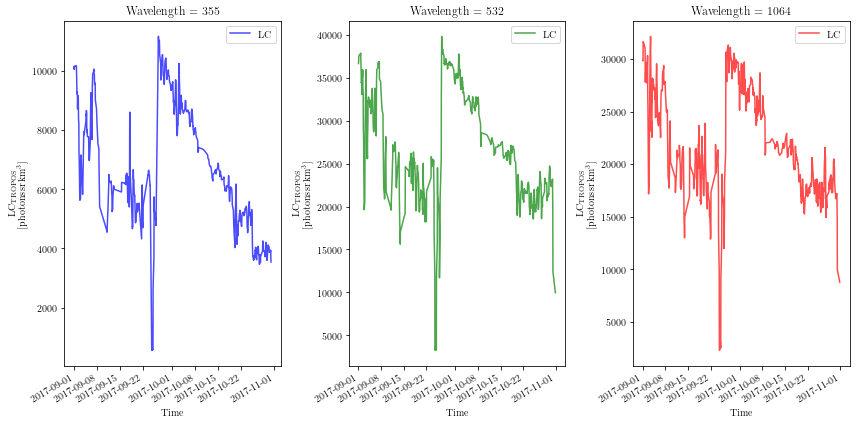

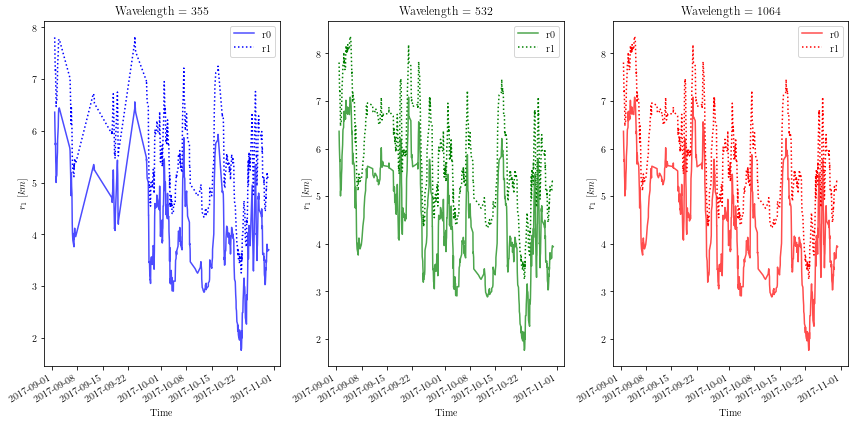

In [4]:
PLOT_PERIOD = True
if PLOT_PERIOD:
	fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
	for wavelength,c,ax in zip(wavelengths,['b','g','r'],axes.ravel()):
		ds_i = ds_extended.sel(Wavelength = wavelength)
		ds_i.LC.rolling(Time =5, center = True).mean().dropna('Time').plot(ax = ax, color=c, alpha = 0.7,label='LC')
		#ds_i.LCrecalc.rolling(Time = 5, center = True).mean().dropna('Time').plot(ax=ax,color=c,linestyle =':',label='LCrecalc')
		#ds_i.LCprecalc.rolling(Time =3, center = True).mean().dropna('Time').plot(ax=ax,color=c,linestyle ='--',label='LCprecalc')
		ax.legend()
	plt.tight_layout()
	plt.show()

	# %% Plot reference heights

	fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
	for wavelength,c,ax in zip(wavelengths,['b','g','r'],axes.ravel()):
		ds_i = ds_extended.sel(Wavelength = wavelength)
		ds_i.r0.rolling(Time = 21, center = True).mean().dropna('Time').plot(ax = ax, color=c, alpha = 0.7,label='r0')
		ds_i.r1.rolling(Time = 21, center = True).mean().dropna('Time').plot(ax=ax,color=c,linestyle =':',label='r1')
		ax.legend()
	plt.tight_layout()
	plt.show()

In [5]:
df_times = ds_extended.Time.to_pandas()
time_00 = datetime.today().time().min
days = [datetime.combine(day,time_00) for day in sorted(df_times.groupby(df_times.dt.date).groups.keys())]
day_number =0
day = days[day_number]
day_str = day.strftime('%Y-%m-%d')
# TODO: check day = 45 ,55(what happened there during interpolation? )

## Profile generation based on TROPOS retrievals
> TODO: extrapolate parameters for missing time

In [6]:
# %%
date_datetime = datetime.strptime(day_str,'%Y-%m-%d')
min_t = datetime.combine(date_datetime.date(), date_datetime.time().min)
max_t = date_datetime + timedelta(hours = 24) - timedelta(seconds = 30)
#max_t = datetime.combine(date_datetime.date(), date_datetime.time().max)
t_slice = slice(min_t,date_datetime.date()+timedelta(days=1))
arr_day = []
time_indx = pd.date_range(start = min_t, end = max_t,freq = '30S')
# %%

## Create calibration daily dataset

In [7]:
# %%
for wavelength in [355,532,1064]:
	ds_i = ds_extended.sel(Wavelength = wavelength,Time= t_slice)#.copy(deep = True)
	ds_i = ds_i.resample(Time='30S').interpolate('nearest')
	ds_i = ds_i.reindex({"Time" : time_indx}, method="nearest",fill_value =  0)
	arr_day.append(ds_i)
ds_day = xr.concat(arr_day,dim = 'Wavelength')

ds_day
ds_smooth = ds_day.apply(func = gaussian_filter1d,sigma=20,keep_attrs =True)
# %%

## Plotting the Lidar constant and reference heights of the day

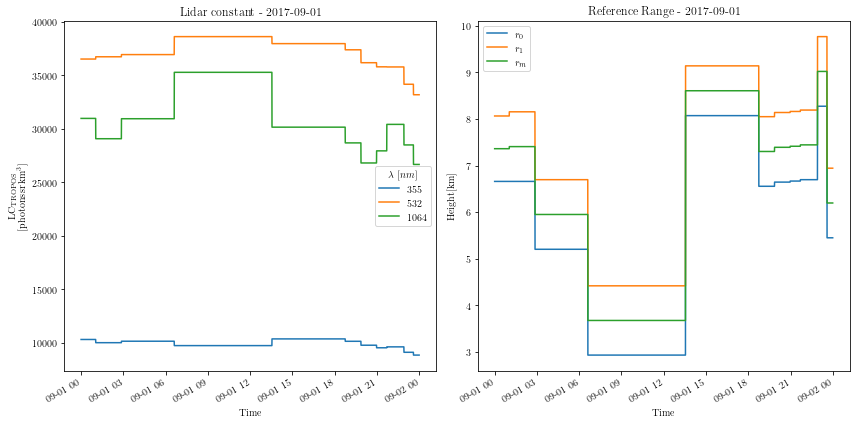

In [8]:
# %%
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax = axes.ravel()
ds_day.LC.plot(x='Time',hue='Wavelength',ax=ax[0])
ax[0].set_title(f'Lidar constant - {day_str}')

for r in ['r0','r1','rm']:
	ds_day[r].sel(Wavelength=355).plot(label=ds_day[r].long_name,ax=ax[1])
ax[1].set_title(f'Reference Range - {day_str}')
ax[1].set_ylabel('Height[km]')
plt.legend()
plt.tight_layout()
plt.show()
# %%

## Generate a daily mean profile of beta (aerosol)

In [9]:
# %%
wavelength = 532
r_min = ds_day.r0.min().item()
r_max = ds_day.r0.max().item()
r_mid = 0.5*(r_max+r_min)
layer_0 = slice(0.0,r_min + 0.25*(r_mid-r_min))# slice(0.0,r_min*1.3)
layer_1 = slice(0.75*r_min,r_mid) #slice(r_min*.70,r_max)
layer_2 = slice(r_mid,r_max)
merged_layer = slice(0.0,r_max)
sampling_ratio = 1E-3*np.array([4,1.5,0.15]) #(10000*np.array([1.0,.25,.125])).astype(np.int)
# %%

In [70]:
# %%
print(f"Generate daily dataset of beta aerosol - {day_str}")
day_date = days[day_number]
daily_paths = sorted(df[df['date']==day_str].groupby(df.profile_path).groups.keys())
aerBsc_profiles_ds = [get_aerBsc_profile_ds(path,df[df['profile_path']==path]) for path in daily_paths]
daily = xr.merge ( aerBsc_profiles_ds , compat = 'no_conflicts' )

Generate daily dataset of beta aerosol - 2017-09-01


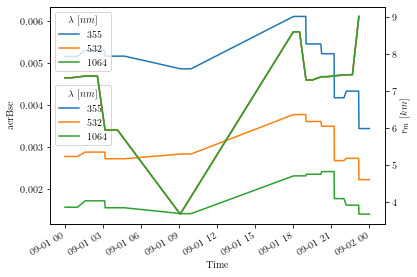

In [68]:
fig, ax = plt.subplots()
daily.aerBsc.max(dim='Height').plot(hue='Wavelength')
ax1= ax.twinx()
ds_extended.sel(Time=slice(day,day+timedelta(days = 1)-timedelta(seconds = 30))).rm.plot(hue='Wavelength',ax=ax1)
plt.show()

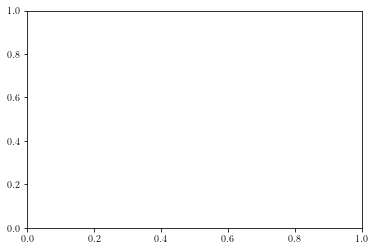

In [90]:
#daily.aerBsc.Time
times = ds_extended.sel(Time=slice(day,day+timedelta(days = 1)-timedelta(seconds = 30))).Time.values
fig, ax = plt.subplots()
for time_i in times:
	dt = datetime.utcfromtimestamp ( time_i.tolist ( ) / 1e9 )
	daily.aerBsc.sel(Time = slice(dt-timedelta(seconds = 15),dt+timedelta(seconds = 15))).max(dim='Height')#.plot(x='Time',hue='Wavelength',ax=ax)
plt.show()


In [ ]:
# Fixing missing timestamps values:
time_indx = pd.date_range ( start = day_date ,
                            end = (day_date + timedelta ( hours = 24 ) - timedelta ( seconds = 30 )) ,
                            freq = '30S' )
daily = daily.reindex ( {"Time" : time_indx} , method="nearest",fill_value = 0 )
daily.attrs = {'location' : station.location ,
                       'info' : 'Daily range corrected lidar signal' ,
                       'source_type' : 'att_bsc'}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
for wavelength,ax in zip([355,532,1064],axes.ravel()):
	daily.aerBsc.sel(Wavelength =wavelength,Height = merged_layer).plot(cmap='turbo',ax = ax)
plt.tight_layout()
plt.show()
# %%

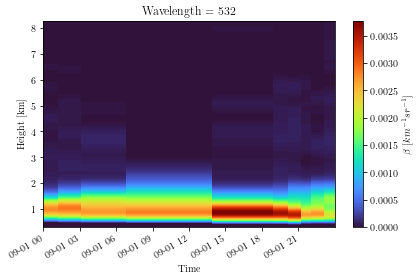

In [11]:
daily.aerBsc.sel(Wavelength =532,Height = merged_layer).plot(cmap='turbo')
plt.tight_layout()
plt.show()

## Subsample, extrapolate and smooth the mean profile to a gat a new daily profile

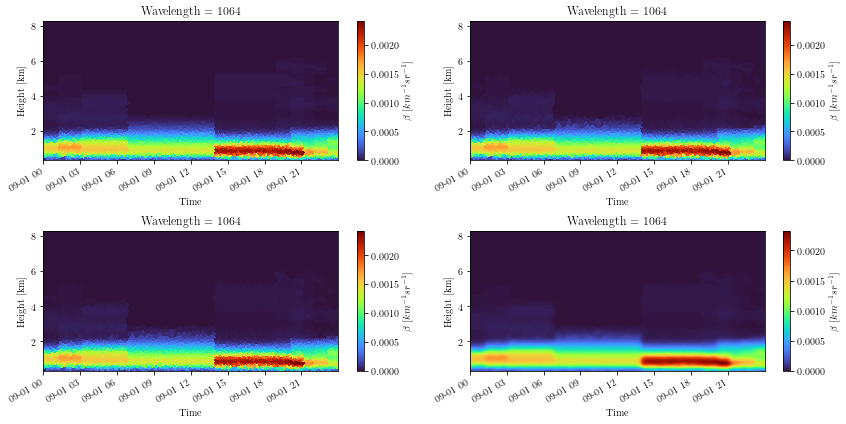

In [12]:
# %%
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
ax = axes.ravel()
tmp = daily.copy(deep = True)
im_layer_0 = tmp.aerBsc.sel(Wavelength=wavelength,Height = layer_0).values
layer_0_sampales = (im_layer_0.size*sampling_ratio[0]).astype(int)
interp_layer_0 = make_interpolated_image(layer_0_sampales,im_layer_0)
interp_layer_0[interp_layer_0<0.0]=eps
tmp.aerBsc.loc[dict(Wavelength=wavelength, Height= tmp.Height.sel(Height = layer_0))] =interp_layer_0
tmp.aerBsc.sel(Wavelength=wavelength,Height = merged_layer).plot(cmap='turbo', ax= ax[0])

im_layer_1 = tmp.aerBsc.sel(Wavelength=wavelength,Height = layer_1).values
layer_1_sampales = (im_layer_1.size*sampling_ratio[1]).astype(int)
interp_layer_1 = make_interpolated_image(layer_1_sampales,im_layer_1)
interp_layer_1[interp_layer_1<0.0]=eps
tmp.aerBsc.loc[dict(Wavelength=wavelength, Height= tmp.Height.sel(Height = layer_1))]=interp_layer_1
tmp.aerBsc.sel(Wavelength=wavelength,Height = merged_layer).plot(cmap='turbo',ax= ax[1])

im_layer_2 = tmp.aerBsc.sel(Wavelength=wavelength,Height = layer_2).values
layer_2_sampales = (im_layer_2.size*sampling_ratio[2]).astype(int)
interp_layer_2 = make_interpolated_image(layer_2_sampales,im_layer_2)
interp_layer_2[interp_layer_2<0.0]=eps
tmp.aerBsc.loc[dict(Wavelength=wavelength, Height= tmp.Height.sel(Height = layer_2))]=interp_layer_2
tmp.aerBsc.sel(Wavelength=wavelength,Height = merged_layer).plot(cmap='turbo',ax= ax[2])

im_merged =  tmp.aerBsc.sel(Wavelength=wavelength,Height = merged_layer).values
blur= gaussian_filter(im_merged,sigma=(11,21))
tmp.aerBsc.loc[dict(Wavelength=wavelength, Height= tmp.Height.sel(Height = merged_layer))]=blur
tmp.aerBsc.sel(Wavelength=wavelength,Height = merged_layer).plot(cmap='turbo',ax= ax[3])
plt.tight_layout()
plt.show()
# %%

## Comparing to original measurements -
### Plotting the rage corrected signal $p \cdot r^2$

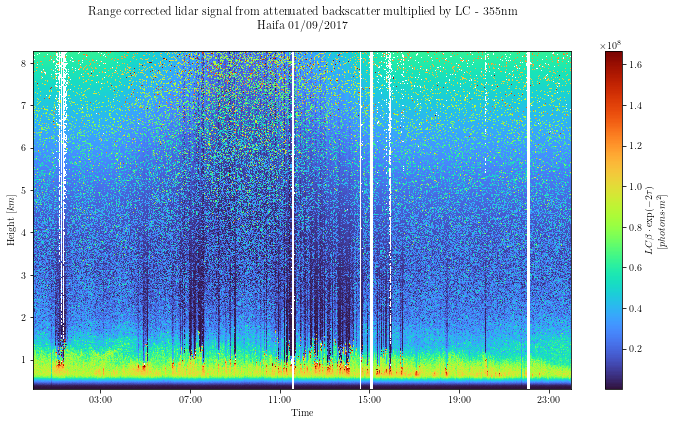

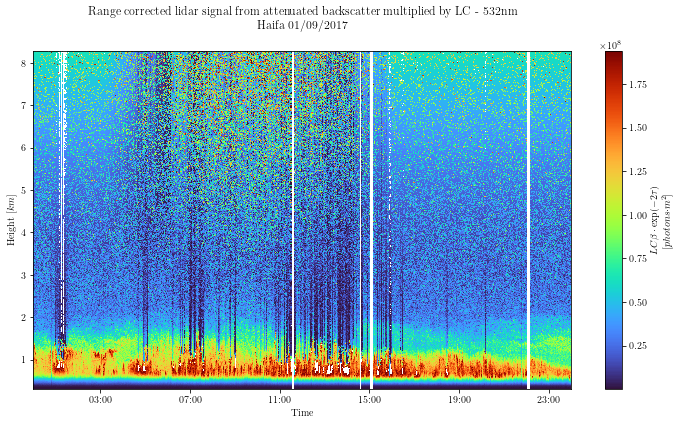

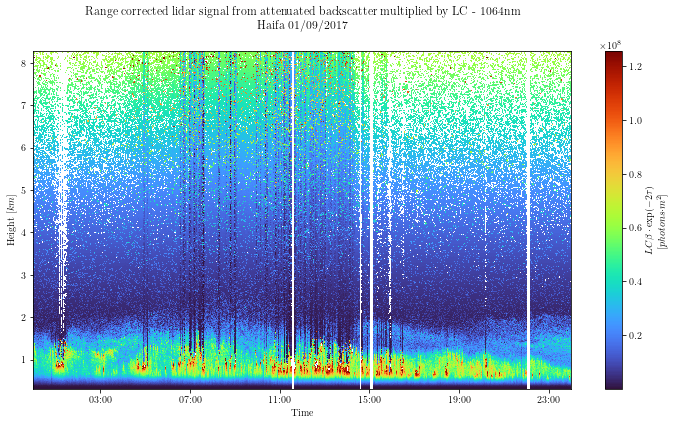

In [13]:
# %%
date_datetime = datetime.strptime(day_str,'%Y-%m-%d') #day_str
file_name = prep.get_prep_dataset_file_name ( station , date_datetime , data_source = 'lidar',lambda_nm = 'all' , file_type = 'all' )
month_folder = prep.get_month_folder_name ( station.lidar_dataset , date_datetime )
lidar_path = os.path.join(month_folder,file_name)
lidar_path
# Load the range corrected profile:
ds_range_corr_daily = prep.load_dataset(lidar_path)
# VISUALIZE RANGE CORRECTED - without limits

wavelengths = ds_range_corr_daily.Wavelength.values.tolist()
for wavelength in wavelengths:
	profile_type = 'range_corr'
	USE_RANGE = 'MID'
	g = prep.visualize_ds_profile_chan(ds_range_corr_daily.sel(Height =merged_layer),
	                                   lambda_nm = wavelength, USE_RANGE = USE_RANGE, profile_type = profile_type)
# %%

In [14]:
altitude_km = station.altitude*1e-3
r = ds_range_corr_daily.Height.sel(Height =merged_layer).values.copy() - altitude_km
r = r.reshape(len(r),1)
dr = r[1]-r[0]
rr = r**2
D = np.hstack([rr+eps]*2880)

## A few efforts to use the measured data for beta and sigma generation
> This is a not really god idea... continuing to to synthizie_lidar_measurments.ipynb

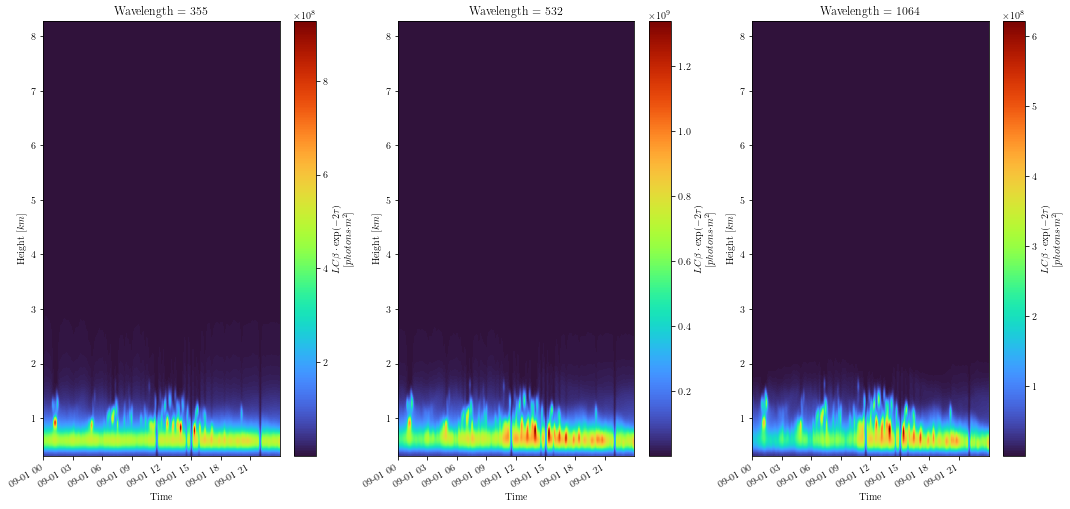

In [15]:
# %%
power_ds = ds_range_corr_daily.sel(Height =merged_layer).copy(deep = True)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,8))

for wavelength,ax  in zip([355,532,1064],axes.ravel()):
	power =  power_ds.range_corr.sel(Wavelength=wavelength,Height = merged_layer).values
	power/=D
	power = np.nan_to_num(power,nan=0.0)
	power[power<=0.0] = 0.0
	blur= gaussian_filter(power,sigma=(9))
	#print(power.max(), blur.max())
	power_ds.range_corr.loc[dict(Wavelength=wavelength,
	                    Height= power_ds.Height.sel(Height = merged_layer))]=blur
	power_ds.range_corr.sel(Wavelength=wavelength,Height = merged_layer).plot(ax=ax,cmap='turbo')
	plt.plot()
# %%

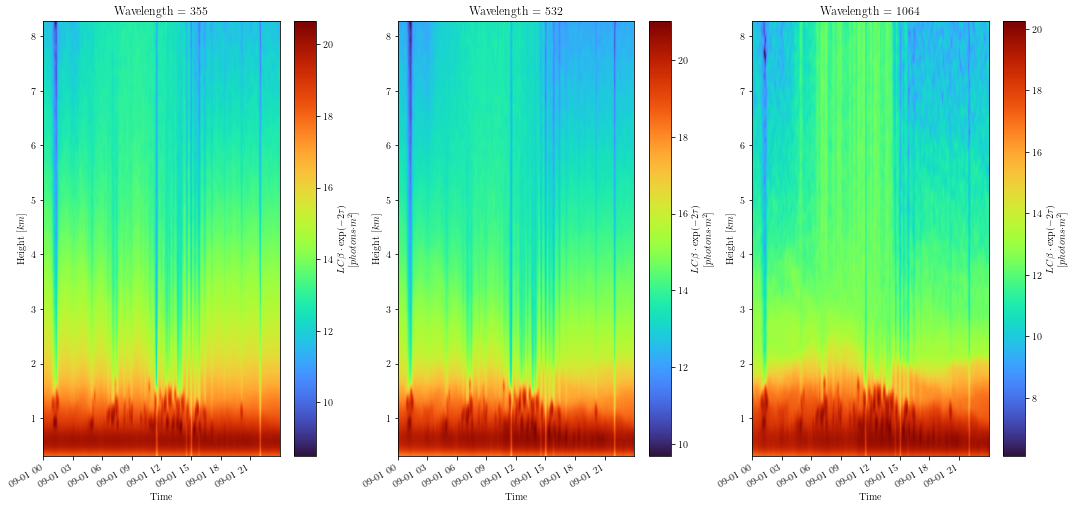

In [16]:
# %%
profile_type = 'range_corr'
USE_RANGE = 'MID'
multiplies = [0.0032,0.0025,0.002 ]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,8))
for wavelength,ax,val in zip(wavelengths,axes.ravel(),multiplies):
	ds_cur = power_ds.sel(Wavelength=wavelength,Height = merged_layer)
	#p_max = ds_cur.range_corr.max(ax=1).item()
	power = np.nan_to_num(ds_cur.range_corr.values,nan=eps)
	#p_max = power.max(axis=0).reshape(1,power.shape[1])
	#P_max = val/np.vstack([p_max]*power.shape[0])
	#power*= val/power.max() # P_max
	power_ds.range_corr.loc[dict(Wavelength=wavelength,
	                             Height= power_ds.Height.sel(Height = merged_layer))]=np.log(power)
	power_ds.range_corr.sel(Wavelength=wavelength,Height = merged_layer).plot(ax=ax,cmap='turbo')
	plt.plot()
	#g = prep.visualize_ds_profile_chan(ds_range_corr_daily.sel(Height =merged_layer),
	#                                   lambda_nm = wav, USE_RANGE = USE_RANGE, profile_type = profile_type)
# %%

In [17]:
#p_max = power.max(axis=0).reshape(1,power.shape[1])
#print(p_max, p_max.shape)
#p_max
#P_max
#power.shape[0]
#ds_cur.range_corr.values.shape
#np.vstack([p_max]*power.shape[0]).T.shape

In [18]:
"""ds_cur.range_corr.values
p_max = ds_cur.range_corr.values.max(axis=0).reshape(1,ds_cur.Time.shape[0])
P_max = np.vstack([p_max]*1295)
power/P_max
"""

'ds_cur.range_corr.values\np_max = ds_cur.range_corr.values.max(axis=0).reshape(1,ds_cur.Time.shape[0])\nP_max = np.vstack([p_max]*1295)\npower/P_max\n'

In [19]:
"""#ds_range_corr_daily.range_corr.attrs['units']= '$photons$'
ds_range_corr_daily['plot_max_range'][0] = 1.0
ds_range_corr_daily['plot_min_range'][0] = 0.0
ds_range_corr_daily['plot_max_range'][1] = 1.0
ds_range_corr_daily['plot_min_range'][1] = 0.0
ds_range_corr_daily['plot_max_range'][2] = 1.0
ds_range_corr_daily['plot_min_range'][2] = 0.0
#print(np.ceil(ds_range_corr_daily.range_corr[0].max().item()))
#print(np.ceil(ds_range_corr_daily.range_corr[1].max().item()))
#print(np.ceil(ds_range_corr_daily.range_corr[2].max().item()))
#
ds_range_corr_daily['plot_max_range']
"""

"#ds_range_corr_daily.range_corr.attrs['units']= '$photons$'\nds_range_corr_daily['plot_max_range'][0] = 1.0\nds_range_corr_daily['plot_min_range'][0] = 0.0\nds_range_corr_daily['plot_max_range'][1] = 1.0\nds_range_corr_daily['plot_min_range'][1] = 0.0\nds_range_corr_daily['plot_max_range'][2] = 1.0\nds_range_corr_daily['plot_min_range'][2] = 0.0\n#print(np.ceil(ds_range_corr_daily.range_corr[0].max().item()))\n#print(np.ceil(ds_range_corr_daily.range_corr[1].max().item()))\n#print(np.ceil(ds_range_corr_daily.range_corr[2].max().item()))\n#\nds_range_corr_daily['plot_max_range']\n"

In [20]:
#power_ds = power_ds.range_corr.fillna(eps)
#power_ds.range_corr[2].max()#.fillna(eps)()

In [21]:
#power =  power_ds.range_corr.sel(Wavelength=532,Height = merged_layer).values.astype(np.float)
#power =  power_ds.range_corr.sel(Wavelength=wavelength,Height = merged_layer).values
#np.nanmax(power, axis=1)
#power.max(axis=1)
#p_max = power.max()

#p_max

In [22]:
# TODO: normalize according to max and min values of the input
# TODO: convert beta and sigma to other channels using angsrom exponent
# TODO: add molecular profile
# TODO: calculate lidar power using sampler from the distribution
# TODO: add mean value of bg to the power
# TODO: create a Poisson signal
# TODO: create a sampler the is changing from layer_0 to layer_1 gradualy similar to LPF .later change the layer settings as the time changes

In [23]:
"""
indx = 100
row = df.iloc[indx]
_,_,ds,slice_ratio=recalc_LC(row)
#slice_ratio

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = axes.ravel()

slice_ratio.attrs['units'] = r'$photons \cdot sr m^{3}$'
slice_ratio.attrs['long_name'] ='LC'
slice_ratio.name =r'$LC$'
slice_ratio.plot(ax=ax[0],cmap='turbo')
ax[0].set_title(fr"$pr^2\big/ \beta_m \cdot \exp(-2\tau_m)$ , \big<LC\big> = {row.LCp_recalc:.2f}")

slice_ratio.where(slice_ratio>=0).plot(ax=ax[1],cmap='turbo')
ax[1].set_title(fr"$pr^2_+\big/ \beta_m \cdot \exp(-2\tau_m) , \big<LC_+\big> =$ {row.LCp_recalc:.2f}")
plt.tight_layout
plt.show()

r0=row.r0
r1 = row.r1"""

# TODO: plot the below part for several samples in the database
# TODO: change the rectangle to heating map
"""profiles = [ 'range_corr' , 'attbsc' ]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,14))
ax = axes.ravel()

p_ds0 = ds[0][profiles[0]]
p_ds1 = ds[1][profiles[1]]
p_ds0.name=r'$pr^2$'
p_ds0.attrs['long_name']=r'$pr^2$'
p_ds1.attrs['long_name'] = r'$\beta_m \cdot \exp(-2\tau_m)$'
p_ds0.sel(Height=slice(0.0,15.0)).plot(ax=ax[0],cmap='turbo')
stime = p_ds0.Time.min().values
etime = p_ds0.Time.max().values
patch = plt.Rectangle(xy=(stime,r0),height = r1-r0, width = etime-stime,facecolor = 'y',alpha=0.2,edgecolor='r')
ax[0].add_patch(patch)
ax[0].set_title(fr"{p_ds0.name} - {int(p_ds0.Wavelength.data)}[{p_ds0.Wavelength.units}]")
p_ds0.sel(Height=slice(0.0,15.0)).where(p_ds0>=0).plot(ax=ax[1],cmap='turbo')
patch = plt.Rectangle(xy=(stime,r0),height = r1-r0, width = etime-stime,facecolor = 'y',alpha=0.2,edgecolor='r')
ax[1].add_patch(patch)
ax[1].set_title(fr"{p_ds0.name}$\geq0$ - {int(p_ds0.Wavelength.data)}[{p_ds0.Wavelength.units}]")
p_ds1.sel(Height=slice(0.0,15.0)).plot(ax=ax[2],cmap='turbo')
patch = plt.Rectangle(xy=(stime,r0),height = r1-r0, width = etime-stime,facecolor = 'y',alpha=0.2,edgecolor='r')
ax[2].add_patch(patch)
ax[2].set_title(fr"{p_ds1.long_name} - {int(p_ds1.Wavelength.data)}[{p_ds1.Wavelength.units}]")


patch = plt.Rectangle(xy=(0,r0),height = r1-r0, width = 120,facecolor = 'y',alpha=0.2,edgecolor='r')
ax[3].add_patch(patch)
p_ds0.sel(Height=slice(0.0,15.0)).mean(dim='Time').plot(ax=ax[3],y='Height',label = fr'$\big<${p_ds0.name}$\big>_t$')
p_ds0.sel(Height=slice(0.0,15.0)).where(p_ds0>=0).mean(dim='Time').plot(ax=ax[3],y='Height',
                                            label = fr'$\big<${p_ds0.name}$\big>_t\geq0$')


p_ds1_LC = p_ds1.copy(deep = True)
p_ds1_LC.data*=row.LC
p_ds1_LC.sel(Height=slice(0.0,15.0)).mean(dim='Time').plot(ax=ax[3],y='Height',linestyle= '--',color='indigo',
                               label = fr'$\big<LC\cdot${p_ds1.long_name}$\big>_t \, ,LC={row.LC:.2f}$')
p_ds1_LC = p_ds1.copy(deep = True)
p_ds1_LC.data*=row.LC_recalc
p_ds1_LC.sel(Height=slice(0.0,15.0)).mean(dim='Time').plot(ax=ax[3],y='Height',linestyle= '-.',color='m',
                               label = fr'$\big<\hat{{LC}}\cdot${p_ds1.long_name}$\big>_t\, ,\hat{{LC}}={row.LC_recalc:.2f}$')
p_ds1_LC = p_ds1.copy(deep = True)
p_ds1_LC.name = r'$photons\cdot m^2$'
p_ds1_LC.data*=row.LCp_recalc
p_ds1_LC.sel(Height=slice(0.0,15.0)).mean(dim='Time').plot(ax=ax[3],y='Height',linestyle=':',color='c',
                               label = fr'$\big<\hat{{LC_+}}\cdot${p_ds1.long_name}$\big>_t\, ,\hat{{LC_+}}={row.LCp_recalc:.2f}$')

ax[3].legend()
ax[3].set_title('Averaged profiles - comparison')
plt.tight_layout
plt.show()

"""

'profiles = [ \'range_corr\' , \'attbsc\' ]\nfig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,14))\nax = axes.ravel()\n\np_ds0 = ds[0][profiles[0]]\np_ds1 = ds[1][profiles[1]]\np_ds0.name=r\'$pr^2$\'\np_ds0.attrs[\'long_name\']=r\'$pr^2$\'\np_ds1.attrs[\'long_name\'] = r\'$\x08eta_m \\cdot \\exp(-2\tau_m)$\'\np_ds0.sel(Height=slice(0.0,15.0)).plot(ax=ax[0],cmap=\'turbo\')\nstime = p_ds0.Time.min().values\netime = p_ds0.Time.max().values\npatch = plt.Rectangle(xy=(stime,r0),height = r1-r0, width = etime-stime,facecolor = \'y\',alpha=0.2,edgecolor=\'r\')\nax[0].add_patch(patch)\nax[0].set_title(fr"{p_ds0.name} - {int(p_ds0.Wavelength.data)}[{p_ds0.Wavelength.units}]")\np_ds0.sel(Height=slice(0.0,15.0)).where(p_ds0>=0).plot(ax=ax[1],cmap=\'turbo\')\npatch = plt.Rectangle(xy=(stime,r0),height = r1-r0, width = etime-stime,facecolor = \'y\',alpha=0.2,edgecolor=\'r\')\nax[1].add_patch(patch)\nax[1].set_title(fr"{p_ds0.name}$\\geq0$ - {int(p_ds0.Wavelength.data)}[{p_ds0.Wavelength.units}

In [24]:
"""
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,8))
ax = axes.ravel()
new_beta = p_ds0.copy(deep = True)
new_beta/=D
new_beta-=p_ds1_LC.data
#new_beta.data[new_beta.data<=0]=0
patch = plt.Rectangle(xy=(0,r0),height = r1-r0,width = etime-stime,facecolor = 'y',alpha=0.2,edgecolor='r')
new_beta.sel(Height=slice(0.0,4.0)).where(new_beta>=1).plot(ax=ax[0],cmap='turbo')
ax[0].add_patch(patch)
patch = plt.Rectangle(xy=(0,r0),height = r1-r0,width = 120,facecolor = 'y',alpha=0.2,edgecolor='r')
new_beta.sel(Height=slice(0.0,15.0)).where(new_beta>=1).mean(dim='Time').plot(ax=ax[1],y='Height')
"""

"\nfig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,8))\nax = axes.ravel()\nnew_beta = p_ds0.copy(deep = True)\nnew_beta/=D\nnew_beta-=p_ds1_LC.data\n#new_beta.data[new_beta.data<=0]=0\npatch = plt.Rectangle(xy=(0,r0),height = r1-r0,width = etime-stime,facecolor = 'y',alpha=0.2,edgecolor='r')\nnew_beta.sel(Height=slice(0.0,4.0)).where(new_beta>=1).plot(ax=ax[0],cmap='turbo')\nax[0].add_patch(patch)\npatch = plt.Rectangle(xy=(0,r0),height = r1-r0,width = 120,facecolor = 'y',alpha=0.2,edgecolor='r')\nnew_beta.sel(Height=slice(0.0,15.0)).where(new_beta>=1).mean(dim='Time').plot(ax=ax[1],y='Height')\n"

In [25]:
"""
new_beta.sel(Height=slice(0.0,15.0)).where(new_beta>=0).mean(dim='Time').plot(ax=ax[1],y='Height')
#ax[1].add_patch(patch)
patch = plt.Rectangle(xy=(0,r0),height = r1-r0,width = etime-stime,facecolor = 'y',alpha=0.2,edgecolor='r')
new_beta.sel(Height=slice(0.0,15.0)).where(new_beta>=0).plot(ax=ax[2],cmap='turbo')
ax[2].add_patch(patch)
maxv = float(new_beta.sel(Height=slice(0.0,15.0)).max().values)
minv = float(new_beta.sel(Height=slice(0.0,15.0)).min().values)
norm_beta = new_beta.copy(deep = True)
norm_beta.data = (norm_beta.data-minv)/(maxv-minv)
patch = plt.Rectangle(xy=(0,r0),height = r1-r0,width = etime-stime,facecolor = 'y',alpha=0.2,edgecolor='r')
norm_beta.where(new_beta>0.0).sel(Height=slice(0.0,15.0)).plot(ax=ax[3],cmap='turbo')
ax[3].add_patch(patch)
#norm_beta.sel(Height=slice(0.0,15.0)).where(new_beta>=0).mean(dim='Time').plot(ax=ax[3],y='Height')
plt.show()
"""

# TODO : median filter(scipy.ndimage.median_filter), dilation, erosion
## TODO: normalize daily beta according to max value of beta during the day


"\nnew_beta.sel(Height=slice(0.0,15.0)).where(new_beta>=0).mean(dim='Time').plot(ax=ax[1],y='Height')\n#ax[1].add_patch(patch)\npatch = plt.Rectangle(xy=(0,r0),height = r1-r0,width = etime-stime,facecolor = 'y',alpha=0.2,edgecolor='r')\nnew_beta.sel(Height=slice(0.0,15.0)).where(new_beta>=0).plot(ax=ax[2],cmap='turbo')\nax[2].add_patch(patch)\nmaxv = float(new_beta.sel(Height=slice(0.0,15.0)).max().values)\nminv = float(new_beta.sel(Height=slice(0.0,15.0)).min().values)\nnorm_beta = new_beta.copy(deep = True)\nnorm_beta.data = (norm_beta.data-minv)/(maxv-minv)\npatch = plt.Rectangle(xy=(0,r0),height = r1-r0,width = etime-stime,facecolor = 'y',alpha=0.2,edgecolor='r')\nnorm_beta.where(new_beta>0.0).sel(Height=slice(0.0,15.0)).plot(ax=ax[3],cmap='turbo')\nax[3].add_patch(patch)\n#norm_beta.sel(Height=slice(0.0,15.0)).where(new_beta>=0).mean(dim='Time').plot(ax=ax[3],y='Height')\nplt.show()\n"